In [1]:
!nvidia-smi

Fri Sep 16 05:18:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-_z2s4prf
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-_z2s4prf
     |████████████████████████████████| 50 kB 7.4 MB/s 
     |████████████████████████████████| 79 kB 10.2 MB/s 
     |████████████████████████████████| 151 kB 65.1 MB/s 
     |████████████████████████████████| 1.4 MB 63.6 MB/s 
     |████████████████████████████████| 509 kB 71.2 MB/s 
     |████████████████████████████████| 248 kB 71.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 96 kB 5.8 MB/s 
     |████████████████████████████████| 843 kB 72.5 MB/s 
     |████████████████████████████████| 117 kB 75.3 MB/s 
  Created whe

In [3]:

import sys
 
 
print("User Current Version:-", sys.version)

User Current Version:- 3.7.14 (default, Sep  8 2022, 00:06:44) 
[GCC 7.5.0]


In [4]:

from platform import python_version
 
 
print("Current Python Version-", python_version())

Current Python Version- 3.7.14


In [5]:
!python -m pip install pyyaml==5.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 9.0 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=fd17a4238a29d686489a597202f15d603c35c5bf7aa6934340c8c541a47a1722
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.2.0 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.


In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
torch:  1.12 ; cuda:  cu113
detectron2: 0.6


In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [3]:
!ls '/content/drive/MyDrive/Colab Notebooks/paddy leaf/ann'

'loh(51).JPG'   test   train


In [4]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode

def get_rust_dicts(directory):
     
    classes = ['stripe rust', 'healthy']
    dataset_dicts = []
    for idx, filename in enumerate([file for file in os.listdir(directory) if file.endswith('.json')]):
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}
        
        filename = os.path.join(directory, img_anns["imagePath"])
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = 528
        record["width"] = 960
      
        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']]
            py = [a[1] for a in anno['points']]
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

from detectron2.data import DatasetCatalog, MetadataCatalog
for d in ["train", "test"]:
    DatasetCatalog.register("paddy_" + d, lambda d=d: get_rust_dicts('/content/drive/MyDrive/Colab Notebooks/paddy leaf/ann/' + d))
    MetadataCatalog.get("paddy_" + d).set(thing_classes=['stripe rust', 'healthy'])
rust_metadata = MetadataCatalog.get("paddy_train")

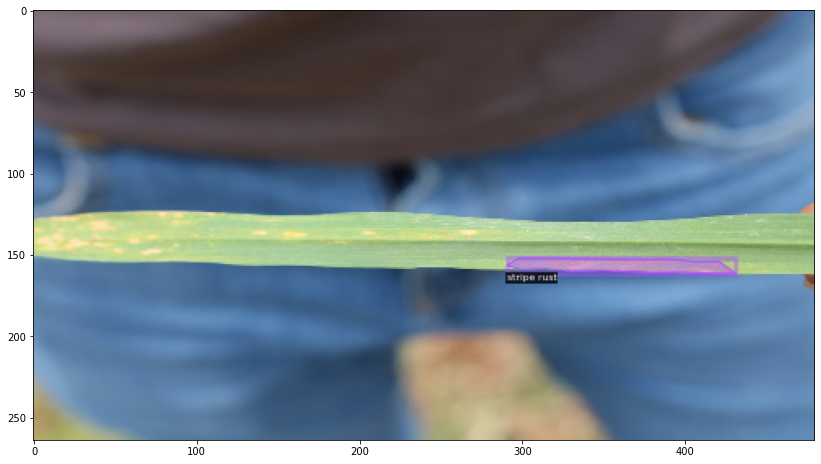

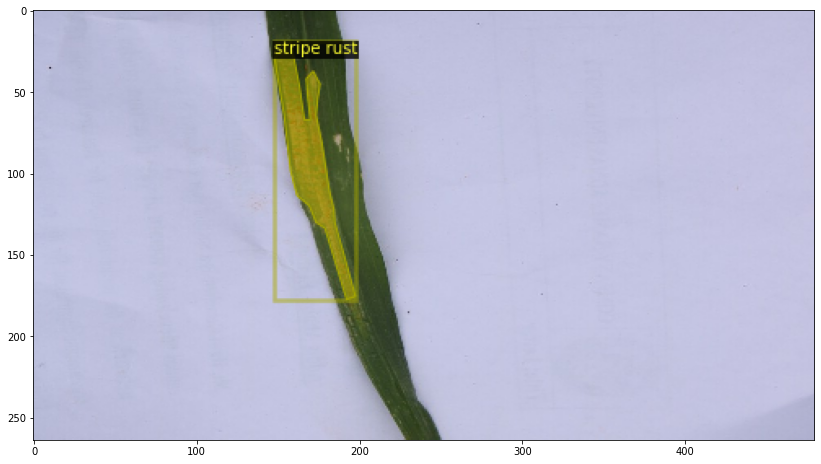

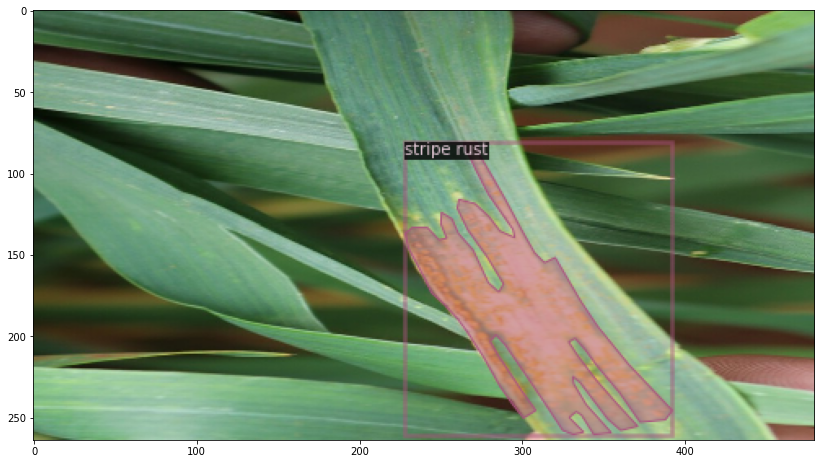

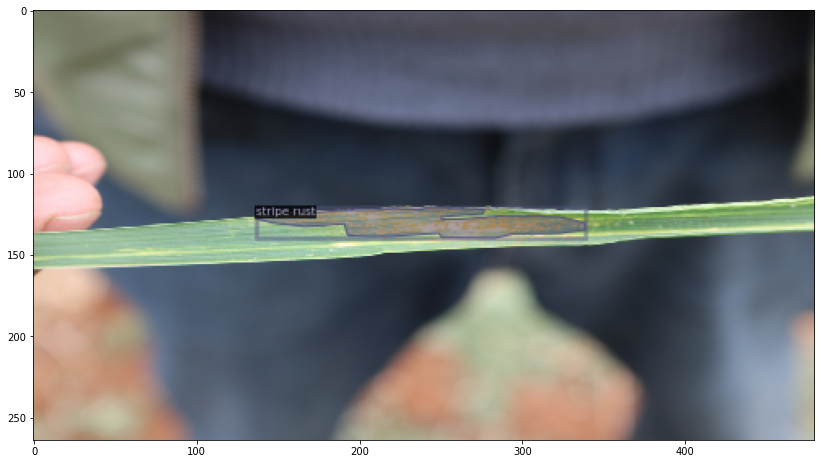

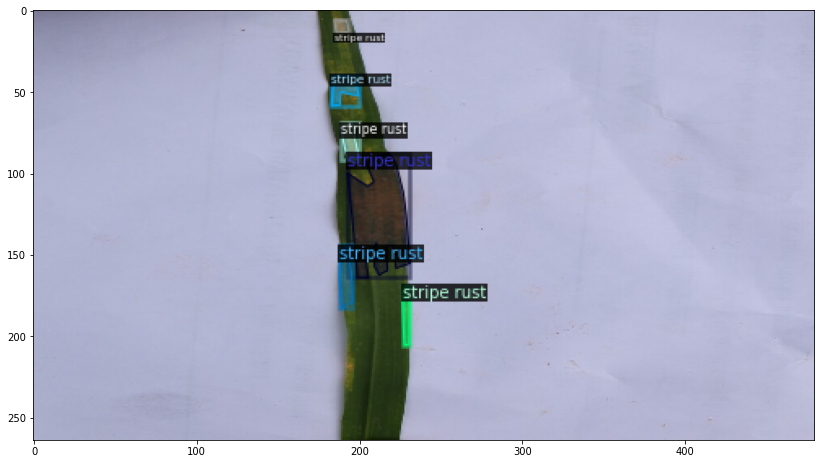

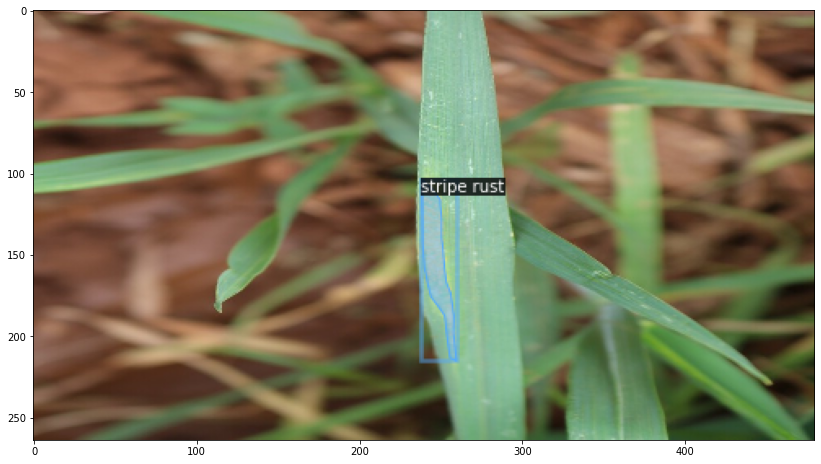

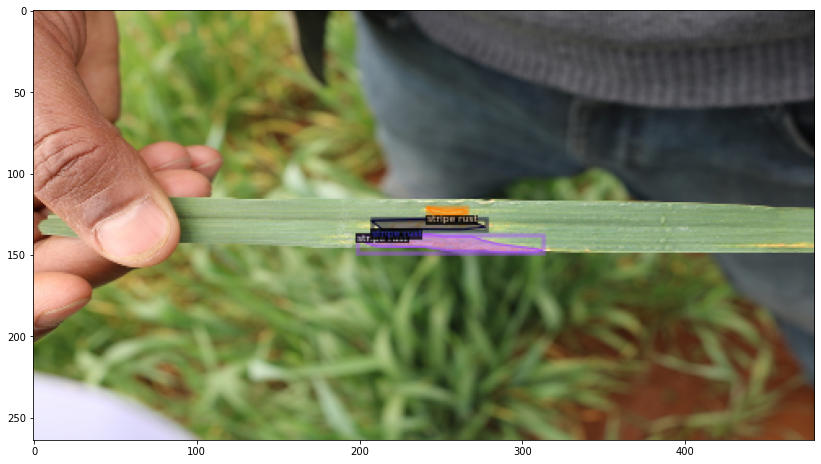

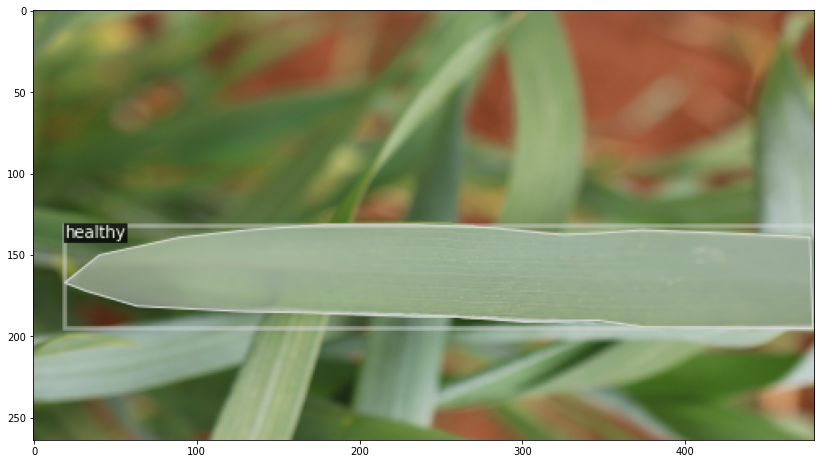

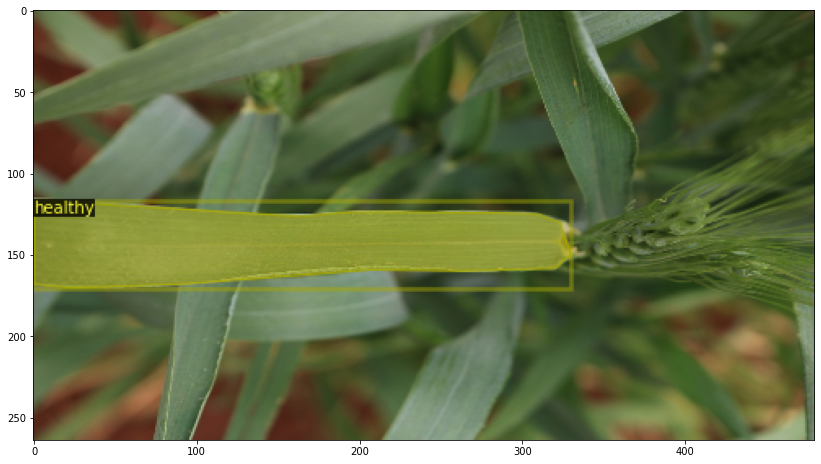

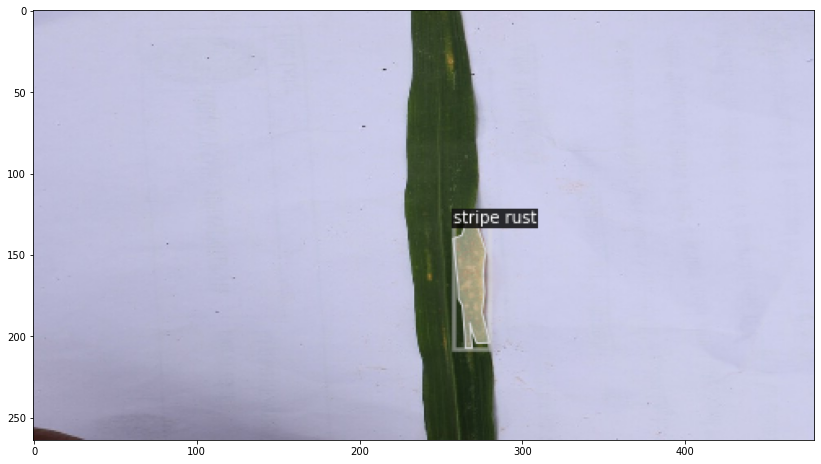

In [5]:
import random

dataset_dicts = get_rust_dicts("/content/drive/MyDrive/Colab Notebooks/paddy leaf/ann/train")
for d in random.sample(dataset_dicts, 10):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=rust_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [6]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("paddy_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[09/16 05:24:52 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:05, 31.0MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[09/16 05:25:04 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[09/16 05:25:24 d2.utils.events]:  eta: 0:08:37  iter: 19  total_loss: 2.808  loss_cls: 1.862  loss_box_reg: 0.03282  loss_mask: 0.6893  loss_rpn_cls: 0.1257  loss_rpn_loc: 0.05514  time: 0.5425  data_time: 0.0228  lr: 4.9953e-06  max_mem: 2582M
[09/16 05:25:35 d2.utils.events]:  eta: 0:08:25  iter: 39  total_loss: 3.107  loss_cls: 1.625  loss_box_reg: 0.03677  loss_mask: 0.6883  loss_rpn_cls: 0.6642  loss_rpn_loc: 0.09983  time: 0.5262  data_time: 0.0087  lr: 9.9902e-06  max_mem: 2582M
[09/16 05:25:45 d2.utils.events]:  eta: 0:08:18  iter: 59  total_loss: 2.174  loss_cls: 1.155  loss_box_reg: 0.04166  loss_mask: 0.6832  loss_rpn_cls: 0.09898  loss_rpn_loc: 0.1017  time: 0.5284  data_time: 0.0088  lr: 1.4985e-05  max_mem: 2582M
[09/16 05:25:56 d2.utils.events]:  eta: 0:08:10  iter: 79  total_loss: 1.734  loss_cls: 0.7762  loss_box_reg: 0.06138  loss_mask: 0.6768  loss_rpn_cls: 0.09797  loss_rpn_loc: 0.1378  time: 0.5318  data_time: 0.0101  lr: 1.998e-05  max_mem: 2582M
[09/16 05:26:08 

In [8]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.DATASETS.TEST = ("rust_test", )
predictor = DefaultPredictor(cfg)

[09/16 05:41:48 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

test img size must be same size as like training img


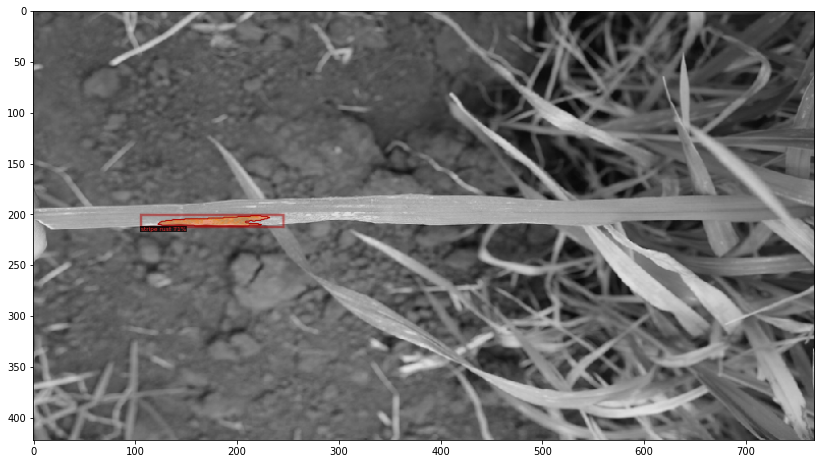

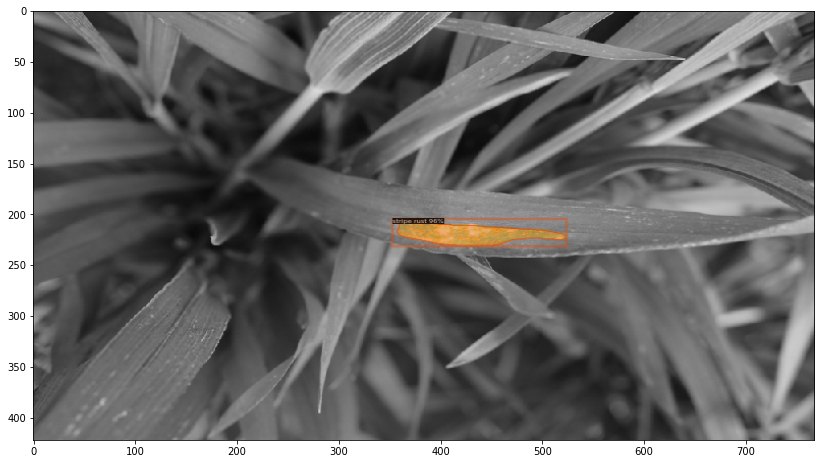

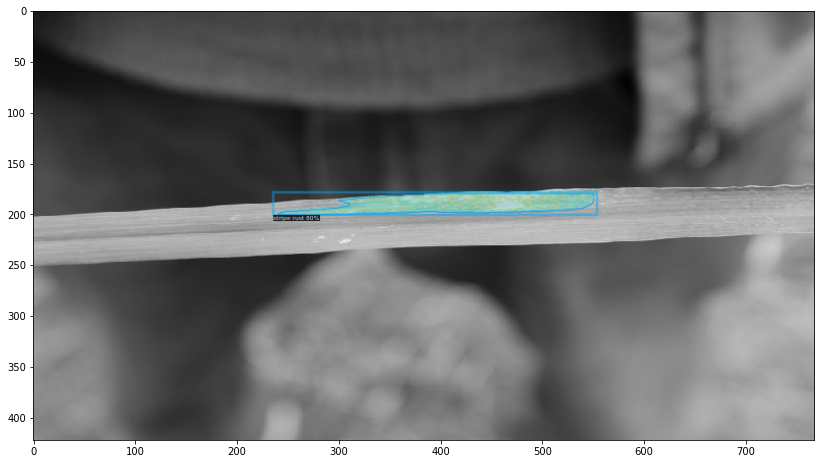

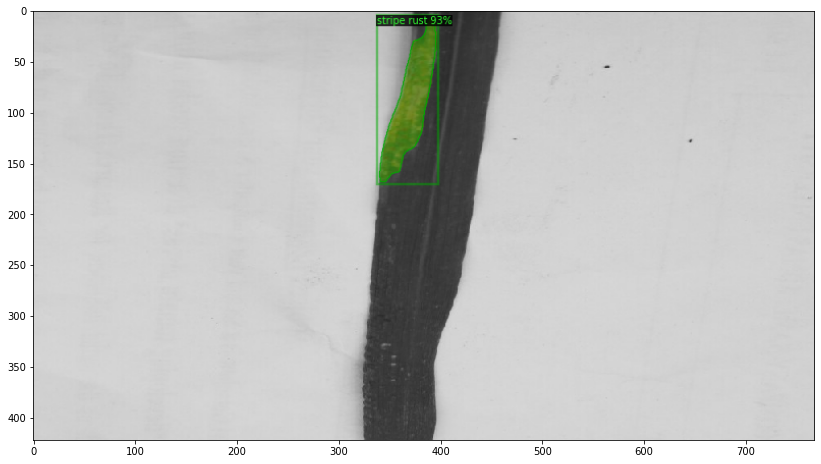

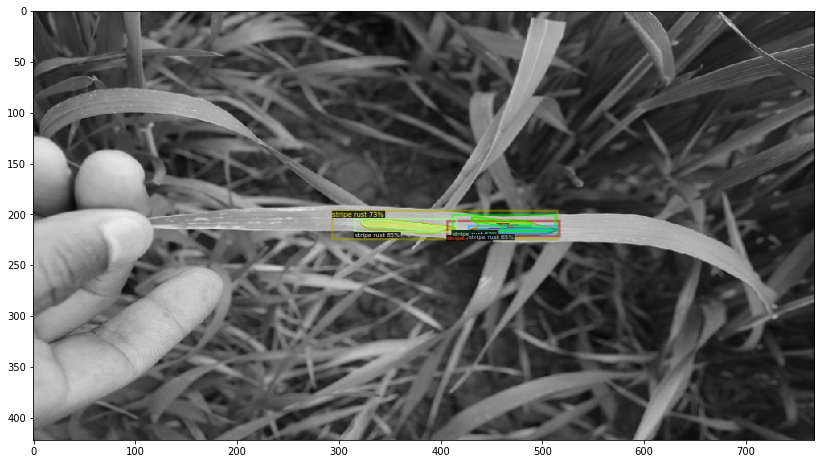

In [10]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_rust_dicts('/content/drive/MyDrive/Colab Notebooks/paddy leaf/ann/train')
for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=rust_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

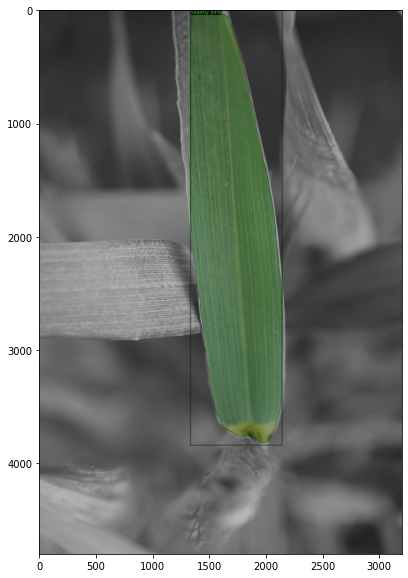

In [12]:
from detectron2.utils.visualizer import ColorMode

im = cv2.imread("/content/drive/MyDrive/Colab Notebooks/paddy leaf/ann/loh(51).JPG")
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
                metadata=rust_metadata, 
                scale=0.8, 
                instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()